# CISA KVE EPSS Data Analyis 

In [1]:
import pandas as pd
import json
import requests
import os
import glob
import numpy as np

In [2]:
cisa_df = pd.read_csv("https://www.cisa.gov/sites/default/files/csv/known_exploited_vulnerabilities.csv")
cisa_df = cisa_df
cisa_df.columns = cisa_df.columns.str.strip("\u200b")
cisa_df = cisa_df.rename(columns={"cveID": "CVE", "shortDescription" : "Description", "dateAdded" : "Date"})

In [3]:
epss = pd.read_csv('epss_scores-current.csv', skiprows=1)
epss = epss.rename(columns={"cve": "CVE", "epss" : "EPSS", "percentile" : "EPSS Percentile"})

In [4]:
row_accumulator = []
for filename in glob.glob('nvdcve-1.1-*.json'):
    with open(filename, 'r', encoding='utf-8') as f:
        nvd_data = json.load(f)
        for entry in nvd_data['CVE_Items']:
            cve = entry['cve']['CVE_data_meta']['ID']
            try:
                base_score = entry['impact']['baseMetricV3']['cvssV3']['baseScore']
            except KeyError:
                base_score = '0.0'
            new_row = { 
                'CVE': cve, 
                'CVSS3': base_score,
            }
            row_accumulator.append(new_row)
        nvd = pd.DataFrame(row_accumulator)
        
nvd['CVSS3'] = pd.to_numeric(nvd['CVSS3']);
nvd['CVSS3'] = nvd['CVSS3'].replace(0, np.nan);       

In [5]:
epss_kev = pd.merge(cisa_df, epss, left_on='CVE', right_on='CVE')
epss_kev_nvd =  pd.merge(epss_kev, nvd, left_on='CVE', right_on='CVE')
epss_kev_nvd =  epss_kev_nvd[["CVE", "CVSS3", "EPSS", "EPSS Percentile", "Description", "Date"]]

## CISA KEV Score Scatter Plot

/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1351: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


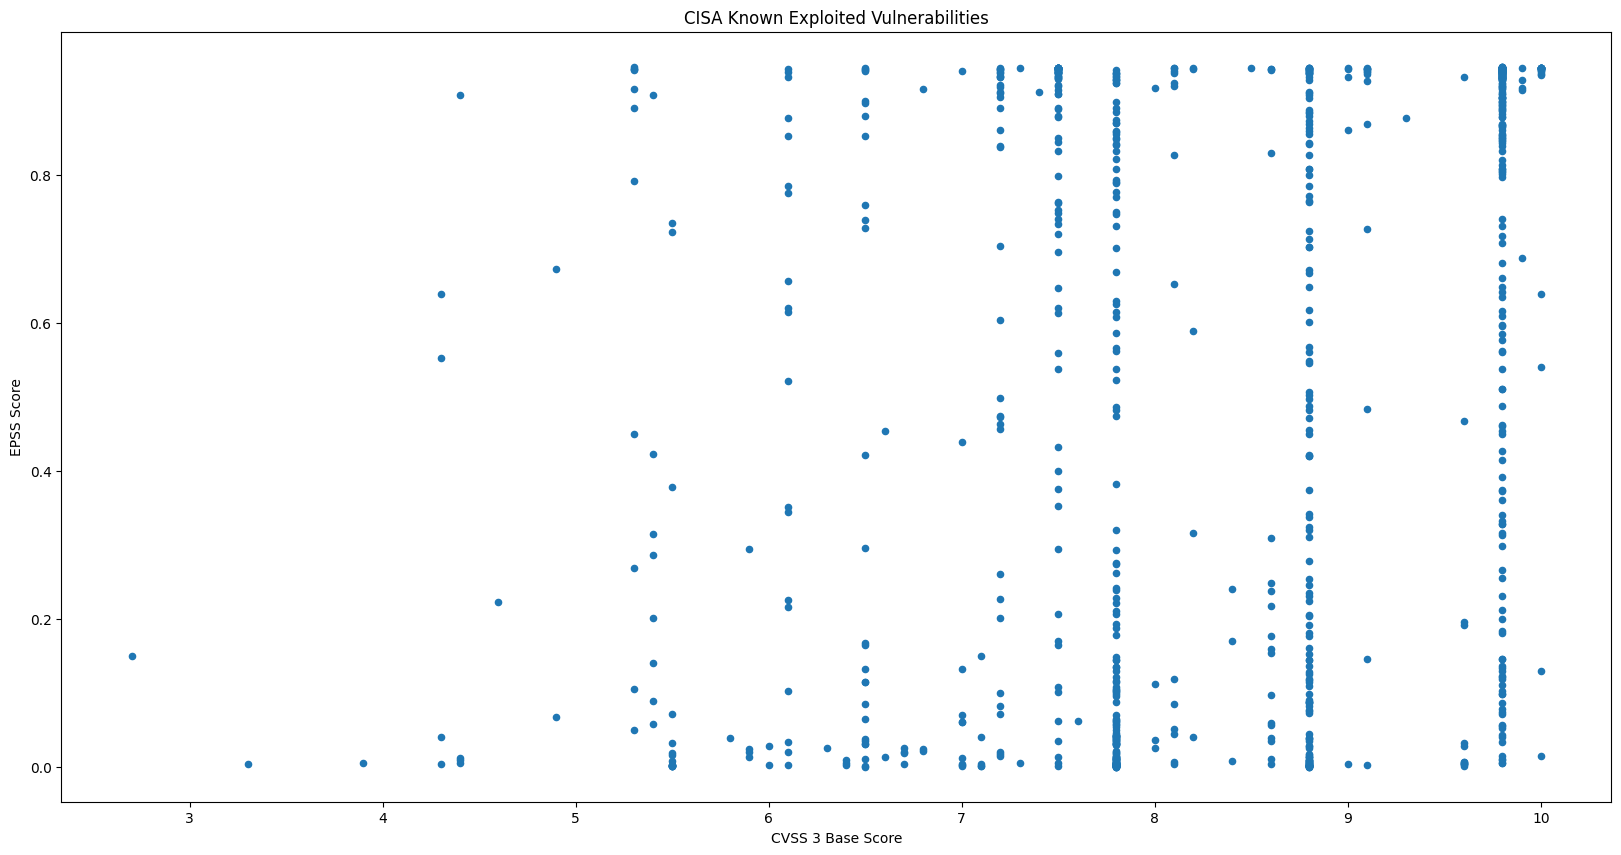

In [6]:
ax = epss_kev_nvd.plot.scatter(x='CVSS3',
                     y='EPSS',
                     colormap='jet',
                     figsize=(20, 10),
                     title='CISA Known Exploited Vulnerabilities');
ax.set_xlabel("CVSS 3 Base Score");
ax.set_ylabel("EPSS Score");
ax.figure.savefig('epss_kev_nvd.png');

## Export to CSV

In [7]:
epss_kev_nvd.to_csv("epss_kev_nvd.csv", index=False)
epss_kev_nvd.head(10)

,CVE,CVSS3,EPSS,EPSS Percentile,Description,Date
0,CVE-2025-8876,NaN,0.17307,0.94766,N-able N-Central contains a command injection ...,2025-08-13
1,CVE-2025-8875,NaN,0.10122,0.92788,N-able N-Central contains an insecure deserial...,2025-08-13
2,CVE-2025-8088,8.8,0.32406,0.96683,RARLAB WinRAR contains a path traversal vulner...,2025-08-12
3,CVE-2020-25078,7.5,0.94264,0.99926,D-Link DCS-2530L and DCS-2670L devices contain...,2025-08-05
4,CVE-2020-25079,8.8,0.54880,0.97941,D-Link DCS-2530L and DCS-2670L devices contain...,2025-08-05
5,CVE-2022-40799,8.8,0.70209,0.98617,D-Link DNR-322L contains a download of code wi...,2025-08-05
6,CVE-2023-2533,8.8,0.47131,0.97589,PaperCut NG/MF contains a cross-site request f...,2025-07-28
7,CVE-2025-20337,10.0,0.01401,0.79629,Cisco Identity Services Engine contains an inj...,2025-07-28
8,CVE-2025-20281,NaN,0.00700,0.71052,Cisco Identity Services Engine contains an inj...,2025-07-28
9,CVE-2025-2775,7.5,0.55876,0.97993,SysAid On-Prem contains an improper restrictio...,2025-07-22
